In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    GridSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from scikitplot.metrics import plot_roc, plot_precision_recall

In [2]:
df_orig = pd.read_csv('dataset/preprocessed_dataset.csv')
df_orig = df_orig.drop(['intensity', 'sc_min', 'stft_min'], axis=1)
df_orig.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,sex,length_ms,frame_count,zero_crossings_sum,mfcc_mean,...,sc_max,sc_kur,sc_skew,stft_mean,stft_std,stft_kur,mean,std,kur,skew
0,1,3,0,0,1,0,3737,179379.0,1.121235,-1.057124,...,13541.959028,0.674807,-0.276204,-0.734044,0.175085,-1.215025,3.844916e-07,0.014482,9.406061,0.706488
1,1,0,0,0,0,0,3904,187387.0,0.278471,-0.164264,...,12000.290443,0.264372,-0.365037,-0.706940,0.883757,-1.384174,-7.149491e-08,0.020417,19.564187,0.748262
2,0,4,1,0,1,0,4671,224224.0,1.592681,-0.395188,...,12007.751173,0.665423,0.250018,-1.163996,0.879099,-1.242947,2.429985e-06,0.024317,4.881241,0.771346
3,1,7,0,1,0,0,3637,174575.0,-0.346031,-1.633922,...,12048.223893,0.297811,-0.707183,-0.830636,1.227493,-1.445318,2.373929e-07,0.003561,13.040259,-0.072032
4,0,4,1,0,1,0,4404,211411.0,0.614322,-0.590964,...,12025.582707,0.628032,0.418192,-0.725278,0.811169,-1.366742,8.454691e-07,0.027522,7.485109,1.018009


In [3]:
df = df_orig.drop(['emotion'], axis=1)
target = df_orig['emotion']

X = df.values
y = target.values

# Partitioning

In [4]:
# stratify: data is split in a stratified fashion, using this as the class labels
# stratified meaning: each set contains approximately the same percentage of samples of each target class as
# the complete set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0
)

In [5]:
# emotions are well distributed between training and test sets
print(np.unique(y, return_counts=True)[1] / len(y))
print(np.unique(y_train, return_counts=True)[1] / len(y_train))
print(np.unique(y_test, return_counts=True)[1] / len(y_test))

[0.15448162 0.15282941 0.07765386 0.15282941 0.15489467 0.07724081
 0.15159025 0.07847997]
[0.15466352 0.15289256 0.07733176 0.15289256 0.15466352 0.07733176
 0.15171192 0.0785124 ]
[0.15405777 0.15268226 0.0784044  0.15268226 0.15543329 0.07702889
 0.15130674 0.0784044 ]


In [6]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1694, 23) (727, 23) (1694,) (727,)


# Decision tree

In [7]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

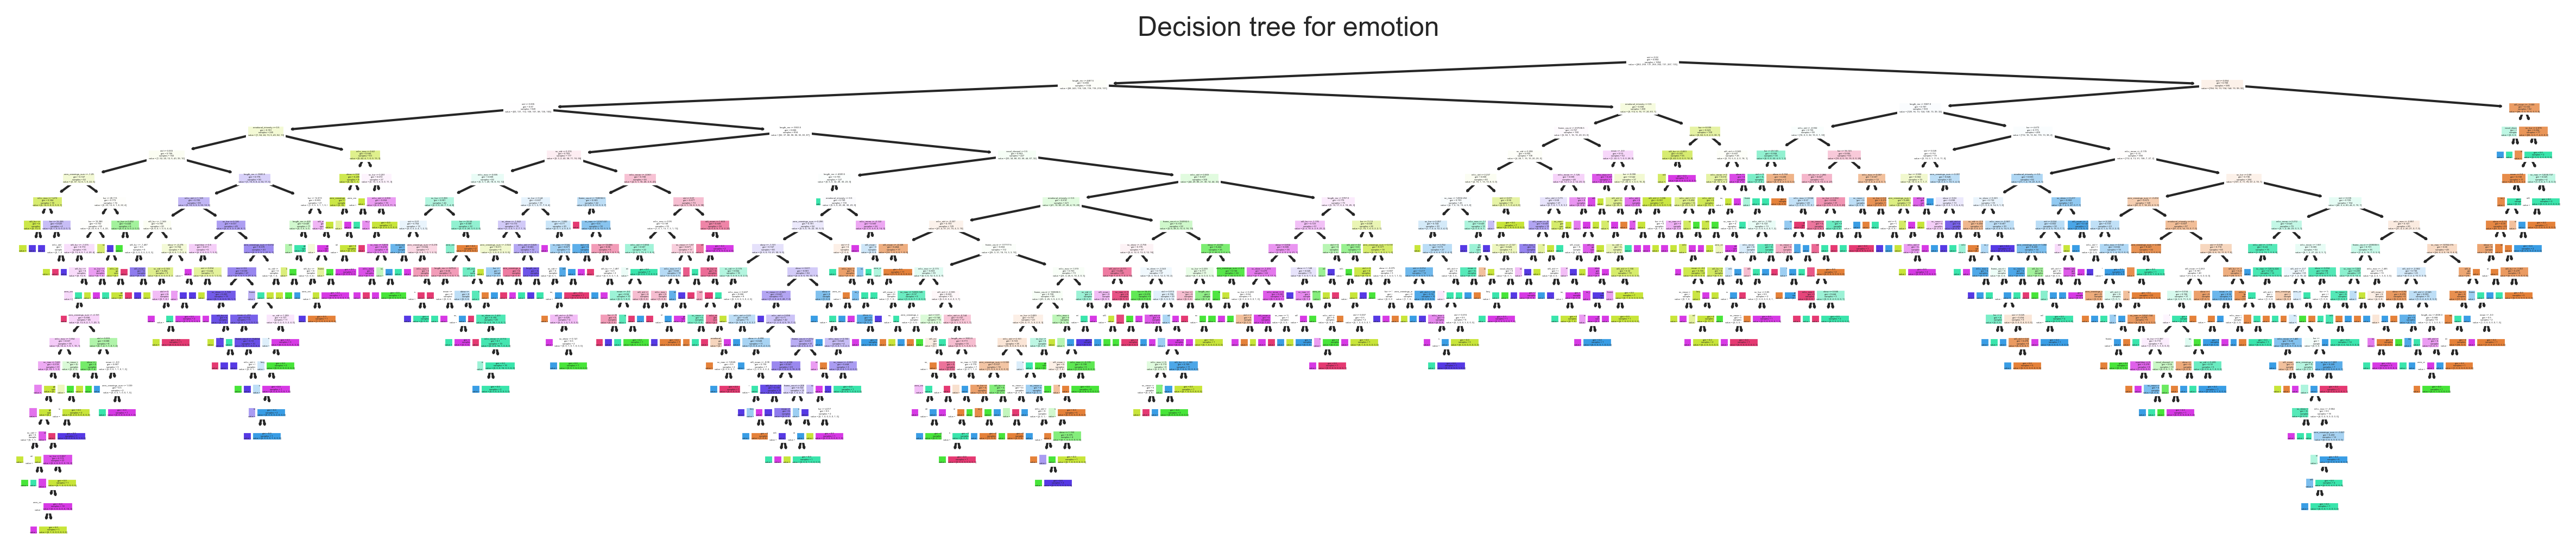

In [8]:
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(clf, feature_names=df.columns, filled=True)
plt.title('Decision tree for emotion')
plt.show()

In [9]:
y_test_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_test_pred))
print(f1_score(y_test, y_test_pred, average='macro'))

0.4126547455295736
0.40419513261134943


In [10]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.56      0.59      0.58       112
           1       0.53      0.50      0.51       111
           2       0.37      0.33      0.35        57
           3       0.34      0.34      0.34       111
           4       0.34      0.33      0.33       113
           5       0.39      0.46      0.42        56
           6       0.39      0.35      0.37       110
           7       0.32      0.35      0.33        57

    accuracy                           0.41       727
   macro avg       0.40      0.41      0.40       727
weighted avg       0.41      0.41      0.41       727



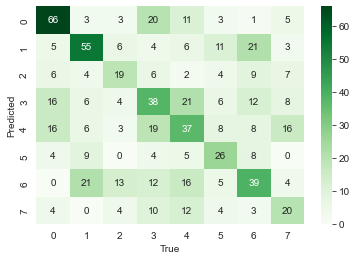

In [11]:
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

In [12]:
y_test_pred_proba = clf.predict_proba(X_test)

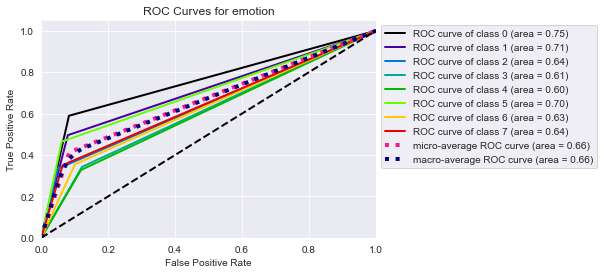

0.6612161841125226


In [13]:
plot_roc(y_test, y_test_pred_proba, title='ROC Curves for emotion')
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr', average='macro'))

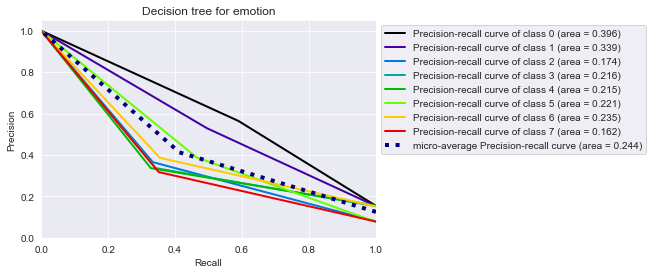

In [14]:
plot_precision_recall(y_test, y_test_pred_proba, title='Precision-Recall Curve for emotion')
plt.legend(bbox_to_anchor=(1,1))
plt.title('Decision tree for emotion')
plt.show()

## Grid search

In [15]:
param_grid = {
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 3, 5, 10],
    'max_depth': [2, 4, 6, 8, 10, 16, 20],
    'criterion': ['gini', 'entropy', 'log_loss']
}

grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0),
    n_jobs=-1,
    refit=True,
)

In [16]:
grid.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8, 10, 16, 20],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'min_samples_split': [2, 3, 5, 10]})

In [17]:
clf = grid.best_estimator_

In [18]:
criterion = grid.best_params_['criterion']
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']
min_samples_split = grid.best_params_['min_samples_split']
print(grid.best_params_, grid.best_score_)

{'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 3} 0.3899588067933882


In [19]:
clf.score(X_test, y_test)

0.3493810178817056

In [20]:
clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                             min_samples_split=min_samples_split)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=16, min_samples_split=3)

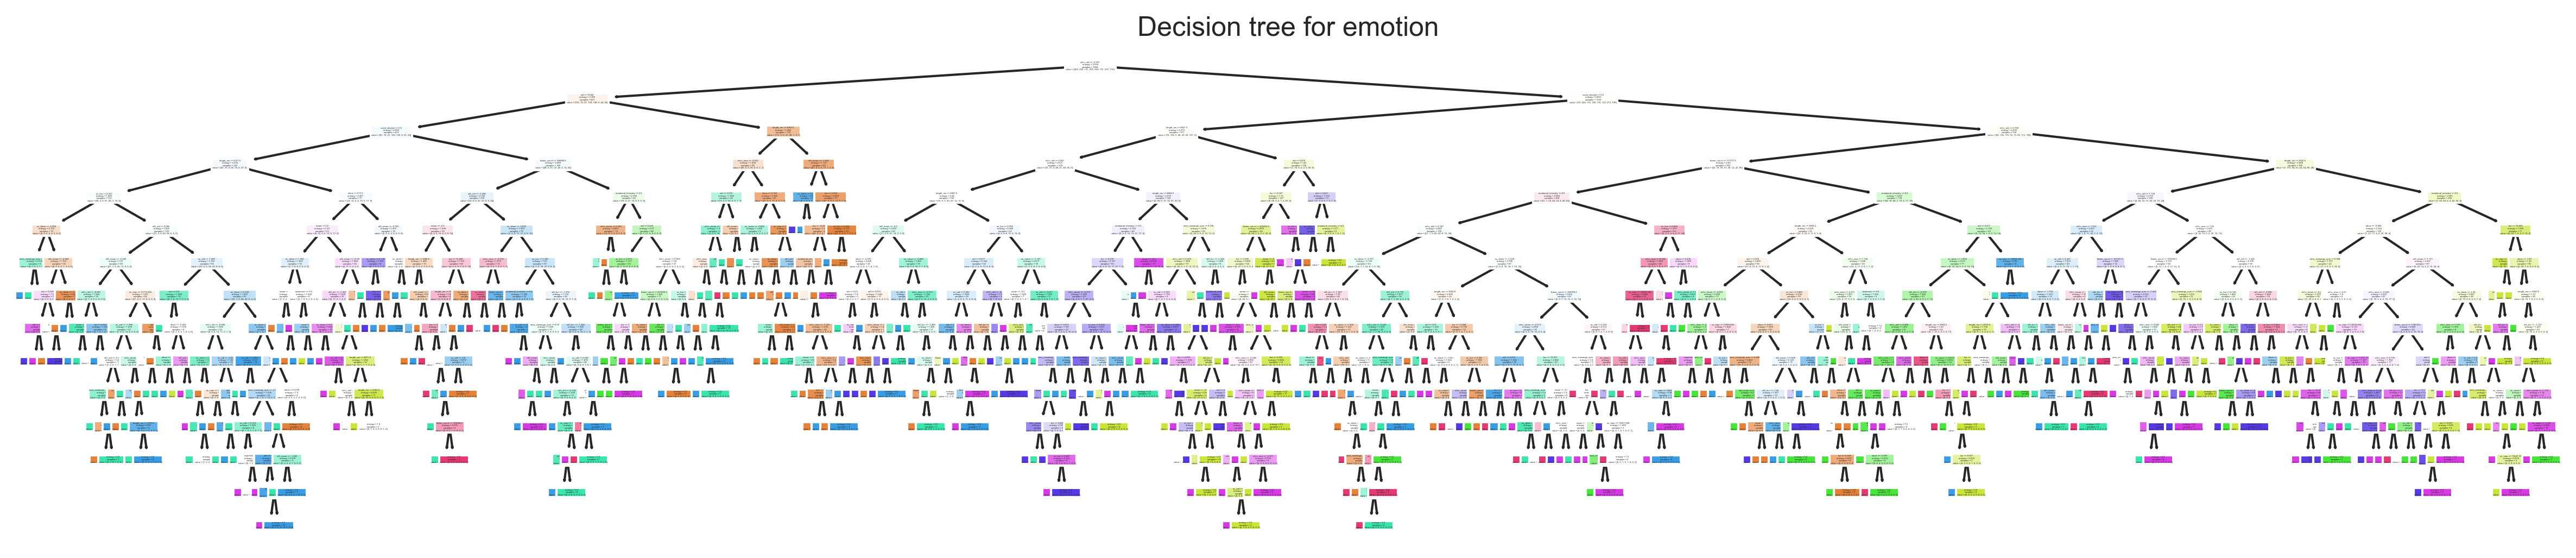

In [21]:
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(clf, feature_names=df.columns, filled=True)
plt.title('Decision tree for emotion')
plt.show()

In [22]:
y_test_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_test_pred))
print(f1_score(y_test, y_test_pred, average='macro'))

0.35900962861072905
0.3354072635557859


In [23]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.50      0.54      0.52       112
           1       0.44      0.43      0.43       111
           2       0.29      0.30      0.29        57
           3       0.38      0.38      0.38       111
           4       0.33      0.35      0.34       113
           5       0.20      0.16      0.18        56
           6       0.30      0.27      0.29       110
           7       0.25      0.26      0.26        57

    accuracy                           0.36       727
   macro avg       0.33      0.34      0.34       727
weighted avg       0.36      0.36      0.36       727



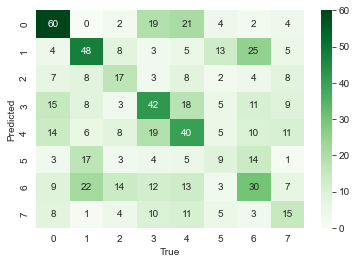

In [24]:
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

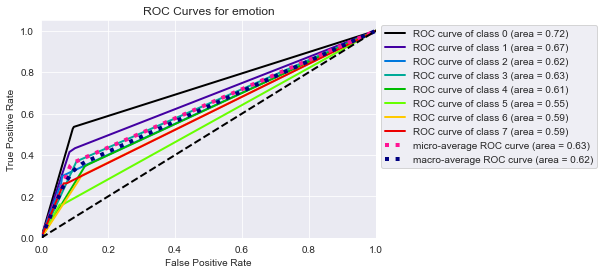

0.6223308157905819


In [25]:
y_test_pred_proba = clf.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba, title='ROC Curves for emotion')
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr', average='macro'))

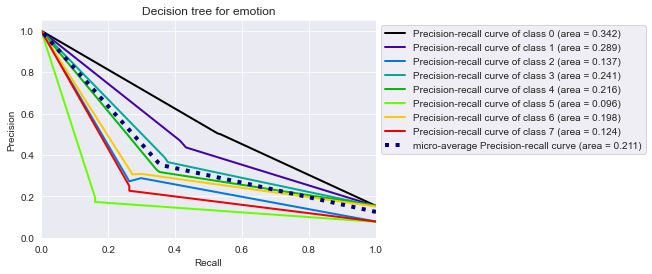

In [26]:
plot_precision_recall(y_test, y_test_pred_proba, title='Precision-Recall Curve for emotion')
plt.legend(bbox_to_anchor=(1,1))
plt.title('Decision tree for emotion')
plt.show()

# KNN

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

In [28]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)

In [29]:
N = X_train.shape[0]
K = int(math.sqrt(N))
clf = KNeighborsClassifier(n_neighbors=K, metric='cityblock', weights='distance')
clf.fit(X_train_scal, y_train)

KNeighborsClassifier(metric='cityblock', n_neighbors=44, weights='distance')

In [30]:
clf.score(X_test_scal, y_test)

0.41030927835051545

In [31]:
param_grid = {
    'n_neighbors': np.arange(1, 200 // 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'cityblock'],
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
)
grid.fit(X_train_scal, y_train)
clf = grid.best_estimator_

In [32]:
print(grid.best_params_, grid.best_score_)

{'metric': 'cityblock', 'n_neighbors': 23, 'weights': 'distance'} 0.41498175231093


In [33]:
clf.score(X_test_scal, y_test)

0.41030927835051545

In [34]:
results = pd.DataFrame(grid.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,...,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002767,0.005269,0.041818,0.026807,euclidean,1,uniform,"{'metric': 'euclidean', 'n_neighbors': 1, 'wei...",0.280928,0.289406,...,0.263566,0.260982,0.275773,0.273902,0.263566,0.289406,0.271318,0.278618,0.019096,394
1,0.000834,0.001132,0.013635,0.007407,euclidean,1,distance,"{'metric': 'euclidean', 'n_neighbors': 1, 'wei...",0.280928,0.289406,...,0.263566,0.260982,0.275773,0.273902,0.263566,0.289406,0.271318,0.278618,0.019096,394
2,0.001080,0.001571,0.040771,0.018416,euclidean,2,uniform,"{'metric': 'euclidean', 'n_neighbors': 2, 'wei...",0.288660,0.289406,...,0.294574,0.286822,0.309278,0.289406,0.286822,0.307494,0.281654,0.299022,0.021166,392
3,0.001095,0.001587,0.024258,0.017195,euclidean,2,distance,"{'metric': 'euclidean', 'n_neighbors': 2, 'wei...",0.280928,0.289406,...,0.263566,0.260982,0.275773,0.273902,0.263566,0.289406,0.271318,0.278618,0.019096,394
4,0.001776,0.004884,0.044079,0.017199,euclidean,3,uniform,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei...",0.319588,0.310078,...,0.281654,0.273902,0.270619,0.286822,0.317829,0.328165,0.279070,0.300001,0.020788,391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,0.000597,0.000313,0.043613,0.008911,cityblock,97,distance,"{'metric': 'cityblock', 'n_neighbors': 97, 'we...",0.394330,0.449612,...,0.374677,0.382429,0.425258,0.359173,0.441860,0.434109,0.382429,0.404185,0.031045,89
392,0.000534,0.000191,0.050781,0.007083,cityblock,98,uniform,"{'metric': 'cityblock', 'n_neighbors': 98, 'we...",0.376289,0.413437,...,0.354005,0.369509,0.391753,0.338501,0.418605,0.382429,0.366925,0.387192,0.027689,186
393,0.000559,0.000241,0.042587,0.006270,cityblock,98,distance,"{'metric': 'cityblock', 'n_neighbors': 98, 'we...",0.396907,0.444444,...,0.385013,0.382429,0.414948,0.361757,0.444444,0.434109,0.382429,0.403773,0.030758,97
394,0.000544,0.000188,0.051026,0.006311,cityblock,99,uniform,"{'metric': 'cityblock', 'n_neighbors': 99, 'we...",0.389175,0.418605,...,0.356589,0.364341,0.378866,0.330749,0.428941,0.397933,0.372093,0.387089,0.028326,187


In [35]:
results['metric_weight'] = results['param_metric'] + ', ' + results['param_weights']

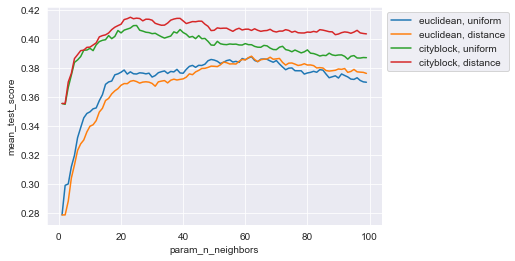

In [36]:
sns.lineplot(data=results, x='param_n_neighbors', y='mean_test_score', hue='metric_weight')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# Naive bayes

## Gaussian

In [37]:
clf = GaussianNB()

In [38]:
clf.fit(X_train, y_train)

GaussianNB()

In [39]:
y_pred = clf.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.51      0.52        75
           1       0.55      0.16      0.25        74
           2       0.22      0.29      0.25        38
           3       0.32      0.16      0.22        74
           4       0.22      0.28      0.25        75
           5       0.00      0.00      0.00        37
           6       0.27      0.22      0.24        74
           7       0.22      0.82      0.34        38

    accuracy                           0.29       485
   macro avg       0.29      0.30      0.26       485
weighted avg       0.32      0.29      0.27       485



In [41]:
clf.predict_proba(X_test)

array([[7.33467565e-02, 1.46006484e-02, 4.28097942e-01, ...,
        4.40382772e-02, 3.71127088e-02, 2.33309029e-01],
       [1.03018171e-01, 1.05100519e-01, 3.28204429e-02, ...,
        1.70963216e-01, 2.09634848e-01, 2.55991009e-05],
       [2.15251270e-01, 2.43621958e-02, 6.05754312e-02, ...,
        1.84037097e-02, 5.66371341e-02, 3.06919794e-03],
       ...,
       [2.85096089e-02, 2.79223588e-01, 2.52597183e-03, ...,
        7.98717146e-02, 4.05741973e-01, 7.84785760e-09],
       [8.59020697e-02, 2.86699013e-02, 3.25384971e-01, ...,
        9.69139737e-02, 5.74049554e-02, 1.42110616e-01],
       [2.70787450e-02, 6.23555236e-02, 5.26002653e-01, ...,
        6.59505409e-02, 2.56002469e-02, 1.23302789e-01]])

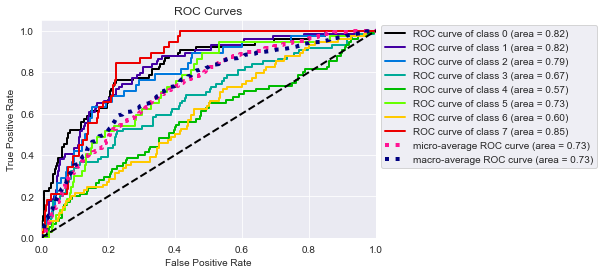

0.7300863786296146


In [42]:
y_test_pred_proba = clf.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr', average='macro'))

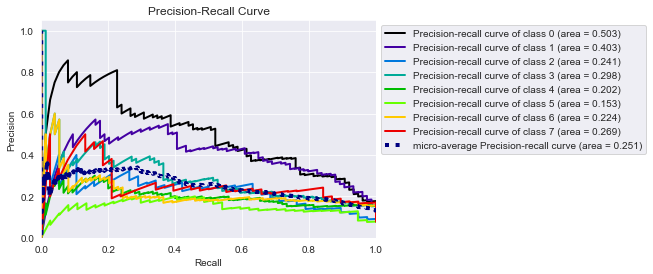

In [43]:
plot_precision_recall(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()